In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_walk = pd.read_csv('input.txt', header=None).T
raw_walk.columns = ['dir']

In [3]:
move = {'n': (0, 2),
        'nw': (-1, 1),
        'sw': (-1, -1),
        's': (0, -2),
        'se': (1, -1),
        'ne': (1, 1)}

In [4]:
start_x = start_y = 0
start = pd.DataFrame([['<start>', start_x, start_y]], columns=['dir', 'x', 'y'])

In [5]:
def do_walk(start, raw_walk):
    subprogram_walk = raw_walk.copy()
    # map 'n', 'ne', etc. moves to vectors
    subprogram_walk['x'] = subprogram_walk['dir'].apply(lambda x: move[x][0])
    subprogram_walk['y'] = subprogram_walk['dir'].apply(lambda x: move[x][1])
    # add in the start position
    subprogram_walk = pd.concat([start, subprogram_walk]).reset_index(drop=True)
    finish = subprogram_walk.sum()
    finish.dir = '<finish>'
    #
    subprogram_walk['pathx'] = subprogram_walk['x'].cumsum()
    subprogram_walk['pathy'] = subprogram_walk['y'].cumsum()
    return subprogram_walk

In [6]:
def step_dist(a, b):
    '''a and b are (x,y) coord pairs of hexagon centres'''
    a_x, a_y, b_x, b_y = *a, *b
    delta_x = a_x - b_x
    delta_y = a_y - b_y
    # distance to nearest axis, moving in ne,nw,se,sw steps
    steps = min(map(abs, (delta_x, delta_y)))
    # remaining distance
    remaining_delta = abs(delta_x) - abs(delta_y)
    if remaining_delta > 0:
        # we hit the x-axis first therefore remaining steps are equal to the remaining delta
        steps += remaining_delta
    elif remaining_delta < 0:
        steps += -remaining_delta/2
    else:
        # we already hit the origin
        pass
    return int(steps)

In [7]:
def walk(start, raw_walk):
    subprogram_walk = do_walk(start, raw_walk)
    subprogram_walk['step_dist'] = subprogram_walk.apply(lambda p: step_dist((start_x, start_y),
                                                                             (p['pathx'], p['pathy'])),
                                                         axis=1)

    p1 = subprogram_walk.tail(1).step_dist.values[0]
    p2 = subprogram_walk.step_dist.max()
    return p1, p2, subprogram_walk

# Part 1/Part 2

In [8]:
p1, p2, subprogram_walk = walk(start, raw_walk)
print(f'part 1 answer: {p1}\npart 2 answer: {p2}')

part 1 answer: 720
part 2 answer: 1485


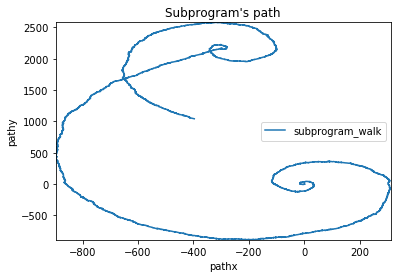

In [9]:
ax = subprogram_walk.plot(x='pathx', y='pathy', label='subprogram_walk', title='Subprogram\'s path')
ax.set_xlim(subprogram_walk.pathx.min(), subprogram_walk.pathx.max())
ax.set_ylim(subprogram_walk.pathy.min(), subprogram_walk.pathy.max())
ax.set_ylabel('pathy')
plt.savefig('subprogram_path.png')

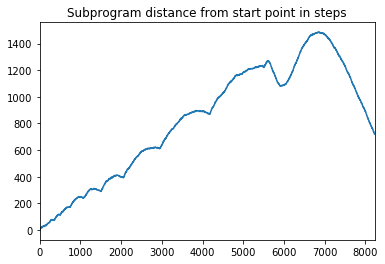

In [10]:
subprogram_walk.step_dist.plot(title='Subprogram distance from start point in steps')

# Examples


    ne,ne,ne is 3 steps away.
    ne,ne,sw,sw is 0 steps away (back where you started).
    ne,ne,s,s is 2 steps away (se,se).
    se,sw,se,sw,sw is 3 steps away (s,s,sw).


In [11]:
from io import StringIO

def raw_walk_from_string(s):
    fd = StringIO(s)
    raw_walk = pd.read_csv(fd, header=None).T
    raw_walk.columns = ['dir']
    return raw_walk

In [67]:
third = 2/3
vertices = [(third, 1),
            (2*third, 0),
            (third, -1),
            (-third, -1),
            (-2*third, 0),
            (-third, 1)]
def do_example(s):
    raw_walk = raw_walk_from_string(s)
    p1, p2, subprogram_walk = walk(start, raw_walk)
    print(f'path: {s}\npart 1 answer: {p1}\npart 2 answer: {p2}')
    ax = subprogram_walk.plot(x='pathx', y='pathy', label='subprogram_walk', title='Subprogram\'s path')
    subprogram_walk.plot(kind='scatter', x='pathx', y='pathy', marker=vertices, s=6000, color='orange', ax=ax)
    ax.set_xlim(subprogram_walk.pathx.min() - 1, subprogram_walk.pathx.max() + 1)
    ax.set_ylim(subprogram_walk.pathy.min() - 1, subprogram_walk.pathy.max() + 1)
    return ax

path: ne,ne,ne
part 1 answer: 3
part 2 answer: 3


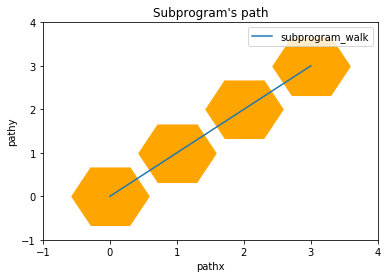

In [68]:
do_example('ne,ne,ne')

path: ne,ne,sw,sw
part 1 answer: 0
part 2 answer: 2


C:\Users\oakden\Anaconda2\envs\dspython362\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


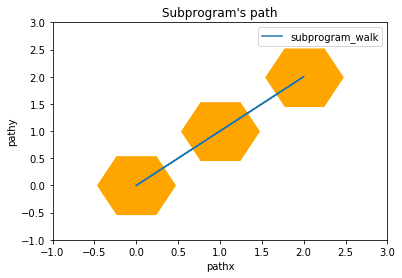

In [69]:
do_example('ne,ne,sw,sw')

path: ne,ne,s,s
part 1 answer: 2
part 2 answer: 2


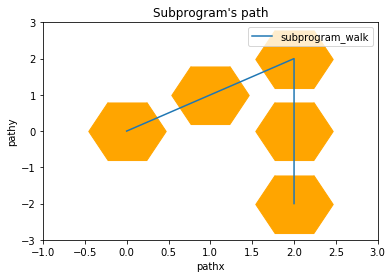

In [70]:
do_example('ne,ne,s,s')

path: se,sw,se,sw,sw
part 1 answer: 3
part 2 answer: 3


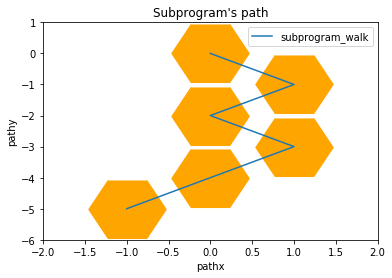

In [71]:
do_example('se,sw,se,sw,sw')